# Upwelling velocities notebook

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean
import os
from datetime import datetime
from matplotlib import gridspec
from salishsea_tools import grid_tools, tidetools, viz_tools, places, utilities

%matplotlib inline
plt.rcParams['font.size'] = 12

## Local functions

Make vertical structure diagram for pressure calculation.

In [3]:
def make_pressure_diagram():
    """Quick plotting code for pressure diagram
    """

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([0.1, 0.8])
    ax.yaxis.set_ticklabels(['$z=-h$', '$z=0$'])

    # Add lines
    x = np.arange(0, 1.01, 0.01)
    for ypos, scale in zip([0.8, 0.1], [6, 15]):
        ax.plot([0, 1], [ypos, ypos], 'k--')
        ax.plot(x, np.sin(2 * np.pi * x - 1.5) / scale + ypos, 'k-')

    # Add labels
    annotations = [
        {'arrow': [0.50, 0.800, 0, 0.140], 'label': [0.505, 0.86], 'str': '$\eta$'},
        {'arrow': [0.50, 0.105, 0, 0.040], 'label': [0.505, 0.12], 'str': '$\\xi$'},
        {'arrow': [0.24, 0.100, 0, 0.680], 'label': [0.245, 0.50], 'str': '$\sum_k^0e3t(0)$'},
        {'arrow': [0.48, 0.175, 0, 0.765], 'label': [0.485, 0.50], 'str': '$\sum_k^0e3t(t)$'},
    ]
    for atn in annotations:
        ax.arrow(*atn['arrow'], head_width=0.01, fc='k')
        ax.text(*atn['label'], atn['str'])

    plt.show()
    
    return

Load and process model results.

In [4]:
def load_results(t, rundir, prefix, maskfile, xrange=[None], yrange=[None]):
    """
    """

    # Load netCDF files
    T = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_T.nc'))
    U = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_U.nc'))
    V = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_V.nc'))
    mask = xr.open_dataset(maskfile)
    
    # Define slices
    xslice = slice(*xrange)
    yslice = slice(*yrange)
    
    # Define parameters
    params = {
        'x': mask.x[xslice].values,
        'y': mask.y[yslice].values,
        'u': U.vozocrtx[t, :, yslice, xslice].values,
        'v': V.vomecrty[t, :, yslice, xslice].values,
        'eta': T.sossheig[t, yslice, xslice].values,
        'tmask': mask.tmask[0, :, yslice, xslice].values,
        'gdept_0': mask.gdept_0[0, :, yslice, xslice].values,
        'e1t': mask.e1t[0, yslice, xslice].values,
        'e2t': mask.e2t[0, yslice, xslice].values,
        'e3t_0': mask.e3t_0[0, :, yslice, xslice].values,
    }
    
    # Obtain the time dependent grid parameters
    VVL = grid_tools.calculate_time_dependent_grid(
        params['e3t_0'], params['tmask'], params['eta'][np.newaxis, ...],
        {'e3t_t': params['e3t_0'][np.newaxis, ...], 'gdept_t': params['gdept_0'][np.newaxis, ...]},
    )
    
    # Calculate rho
    rho = gsw.rho(T.vosaline[t, :, yslice, xslice], T.votemper[t, :, yslice, xslice], VVL['gdept_t'][0, ...])
    
    # Finalize output dict
    params.update({
        'rho': rho,
        'e3t_t': VVL['e3t_t'][0, ...],
        'gdept_t': VVL['gdept_t'][0, ...],
    })
    
    return params

Calculate the depth of a constant density surface.

In [5]:
def calc_sigma_surface():
    """Calculate 1022 surface depth
    """
    
    index = abs(rho - 1022).argmin(axis=1)
    p, _, m, n = VVL['gdept_t'].shape
    depth_1022 = np.zeros((p, m, n))
    for t in range(p):
        for j in range(m):
            for i in range(n):
                depth_1022[t, j, i] = VVL['gdept_t'][t, index[t, j, i], j, i]
                
    return depth_1022

Plot the pressure and velocity fields.

In [100]:
def plotit(z, GEO, params, plevels=np.arange(35.128, 35.14, 0.001), layout='row', scales=[1, 1, 1], lims=[20, 125, 0, 470]):
    """Plot idealized model results
    """
    
    # Make figure
    if layout is 'row':
        fig, axs = plt.subplots(1, 4, figsize=(17, 18))
        cax = fig.add_axes([0.29, 0.15, 0.01, 0.7])
    elif layout is 'grid':
        fig, axs = plt.subplots(2, 2, figsize=(17, 25), gridspec_kw={'hspace': 0.01})
        axs = axs.reshape(4)
        cax = fig.add_axes([0.5, 0.55, 0.01, 0.3])

    # Loop through panels
    for ax, scale, tag in zip(axs, [1] + scales, ['p', '', '_g', '_a']):
        
        # Plot model parameters
        if tag is 'p':  # ----- Pressure
            levels = plevels
            c = ax.contourf(
                params['x'], params['y'], GEO['pressure']*1e-4,
                levels=levels, cmap=cmocean.cm.deep, extend='both', zorder=0,
            )
        else:  # -------------- Velocity
            mindex = (abs(GEO[f'u{tag}']) > 0.1) | (abs(GEO[f'v{tag}']) > 0.1)
            u = np.ma.masked_where(mindex, GEO[f'u{tag}'])
            v = np.ma.masked_where(mindex, GEO[f'v{tag}'])
            q = ax.quiver(params['x'][::5], params['y'][::5], u[::5, ::5], v[::5, ::5], scale=scale, zorder=2)
            qkey = ax.quiverkey(q, 0.8, 0.8, 0.1, '0.1 m/s')
            qkey.set_zorder(5)
            ax.text(0.8, 0.85, f'u{tag}', transform=ax.transAxes)
            ax.yaxis.set_ticklabels('')
        
        # Formatting
        ax.contourf(params['x'], params['y'], params['tmask'][z, ...], levels=[-0.01, 0.01], colors='Burlywood', zorder=3)
        ax.contour(params['x'], params['y'], params['tmask'][z, ...], levels=[-0.01, 0.01], colors='k', zorder=3)
        ax.set_xlim(lims[:2])
        ax.set_ylim(lims[2:])
        viz_tools.set_aspect(ax)

    # Annotations
    fig.colorbar(c, cax=cax)
    
    return

## Velocity decomposition
We would like to show that the ageostrophic velocities in the lower layer of the model are onshore and stronger near protruding coastlines.

First we calculate the total pressure field

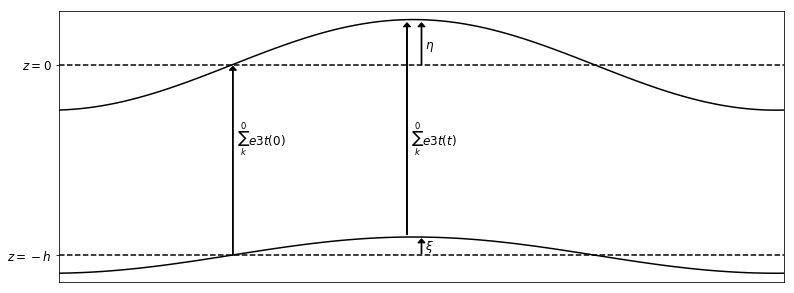

In [7]:
make_pressure_diagram()

$$\xi = \eta - \left(\sum_k^0e3t(t) - \sum_k^0e3t(0)\right)$$

$$p = g\int_{-h}^\eta\rho dz = g\int_{-h+\xi}^\eta\rho dz + g\rho_{deep}\xi$$

Next, we calculate the geostrophic velocities from the pressure gradient force.

$$f \times \mathbf{u}_g = -\frac{1}{\rho}\nabla p$$

$$\mathbf{u}_a = \mathbf{u} - \mathbf{u}_g$$

In [8]:
def calc_geostrophic_velocities(z, params, corr=False):
    """Calculate pressure gradients and geostrophic velocities at idepth
    """
    
    # Geostrophic parameters dict
    GEO = {}
    
    # Define constants
    g = 9.81
    f = 1e-4

    # Calculate z surface displacement xi
    stretching = params['e3t_t'][:z, ...].sum(axis=0) - params['e3t_0'][:z, ...].sum(axis=0)
    xi = params['eta'] - stretching

    # Define rho at z surface
    rho_bot = params['rho'][z, ...]
    rho_bot[xi < 0] = params['rho'][z - 1, ...][xi < 0]

    # Calculate pressure
    GEO['pressure'] = g * ((params['rho'][:z, ...] * params['e3t_t'][:z, ...]).sum(axis=0) + rho_bot * xi)
    
    if corr:
        py = np.ma.masked_where(params['tmask'][z, ...] == 0, GEO['pressure']).mean(axis=1)[..., np.newaxis]
        GEO['pressure'] = GEO['pressure'] - py + py.mean(axis=0)

    # Calculate the pressure gradient
    dpdy, dpdx = np.gradient(GEO['pressure'], axis=(0, 1))

    # Extract and unstagger the model velocity fields
    GEO['u'] = params['u'][z, ...]
    GEO['v'] = params['v'][z, ...]
    GEO['u'][1:, 1:], GEO['v'][1:, 1:] = viz_tools.unstagger(GEO['u'], GEO['v'])

    # Calculate the geostrophic velocities
    GEO['u_g'] = -1 / (f * params['rho'][z, ...]) * dpdy / params['e2t']
    GEO['v_g'] = 1 / (f * params['rho'][z, ...]) * dpdx / params['e1t']

    # Calculate ageostrophic velocities
    GEO['u_a'] = GEO['u'] - GEO['u_g']
    GEO['v_a'] = GEO['v'] - GEO['v_g']

    return GEO

## Idealized configuration

In [9]:
rundir = '/data/bmoorema/results/SalishSeaPond/SalishSeaPond_basic_summer_S24H_2layer'
prefix = 'SalishSeaIdeal_1h_20170701_20170705'
maskfile = os.path.join(rundir, 'mesh_mask.nc')
z = 24
t = 40
lims=[20, 125, 0, 470]
params = load_results(t, rundir, prefix, maskfile, xrange=lims[:2], yrange=lims[2:])

### No correction

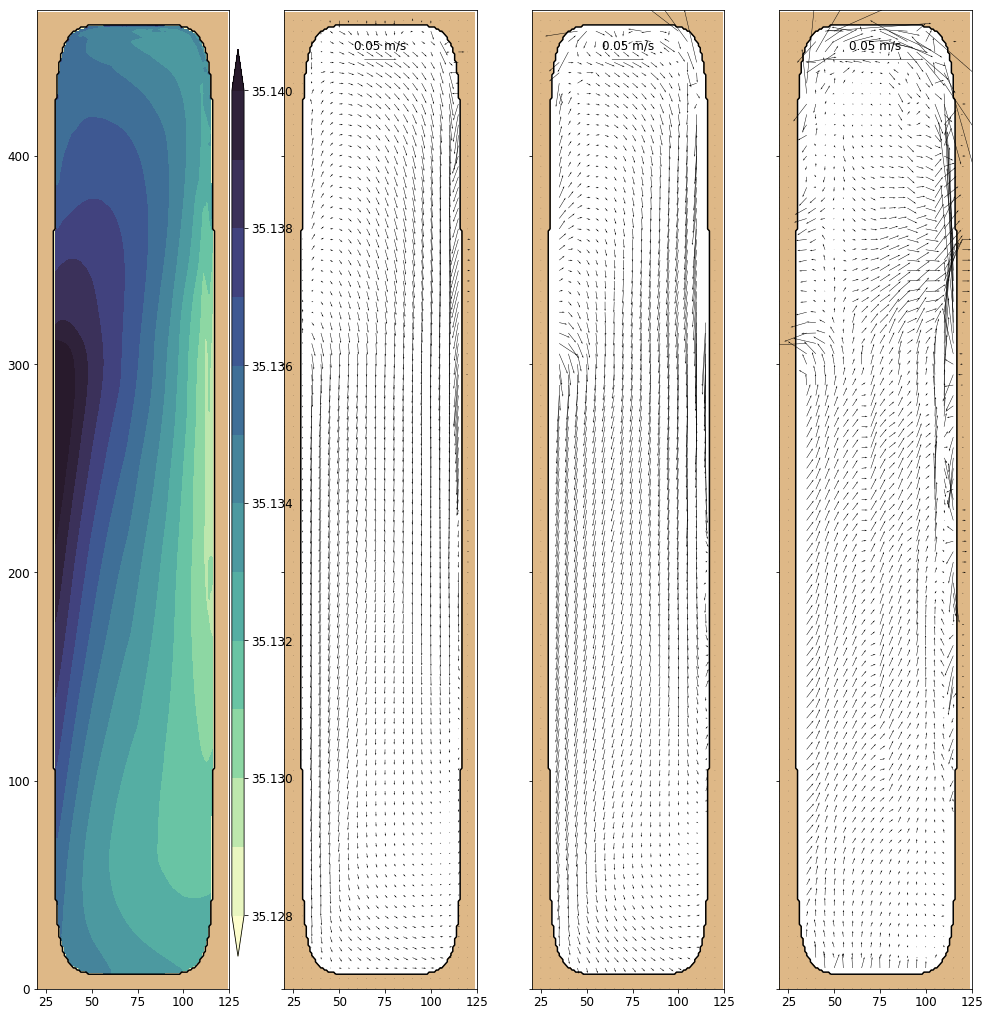

In [23]:
GEO = calc_geostrophic_velocities(z, params)
plotit(z, GEO, params, scales=[0.3, 0.3, 0.1], lims=lims)

### With correction

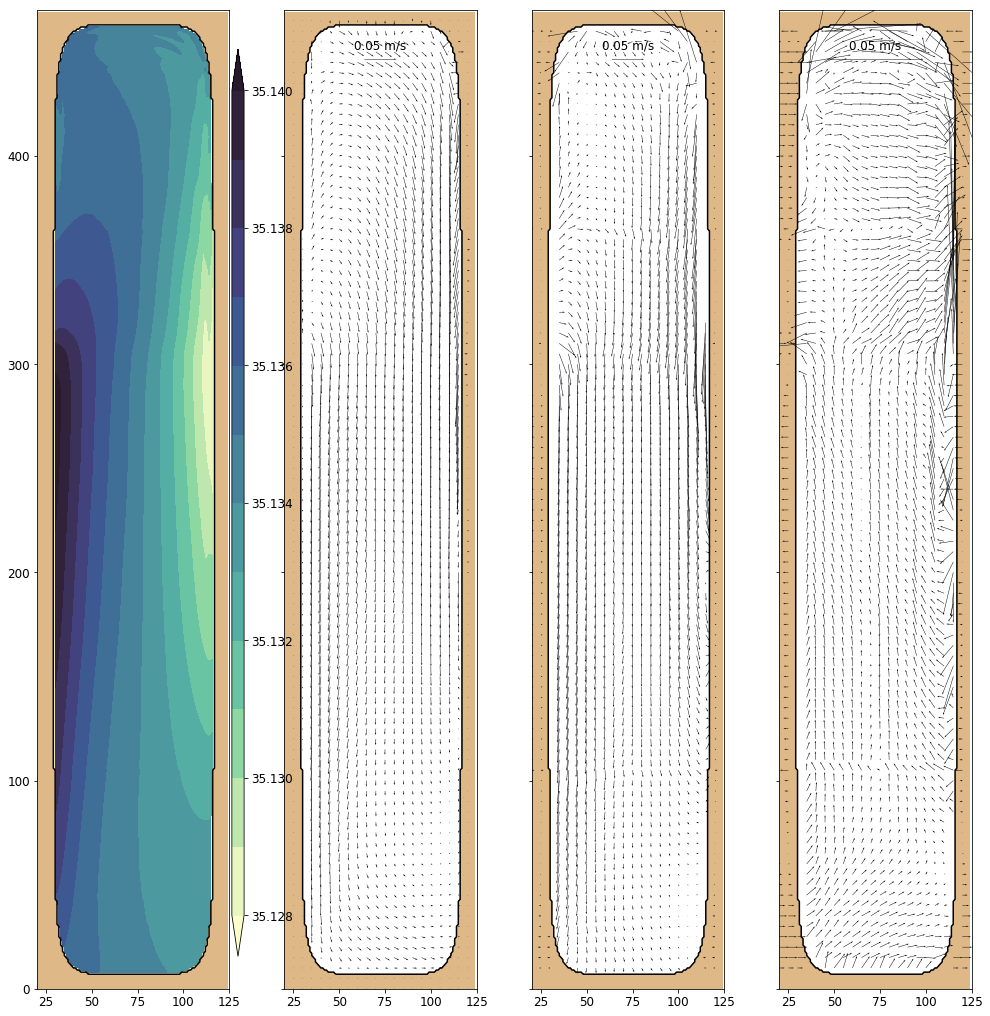

In [24]:
GEO = calc_geostrophic_velocities(z, params, corr=True)
plotit(z, GEO, params, scales=[0.3, 0.3, 0.1], lims=lims)

## Full configuration - no tides

In [82]:
rundir = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake'
prefix = 'SalishSea_1h_20150424_20150429'
maskfile = '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc'
z = 23
t = 70
lims=[100, 300, 400, 750]
params = load_results(t, rundir, prefix, maskfile, xrange=lims[:2], yrange=lims[2:])

### No correction

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


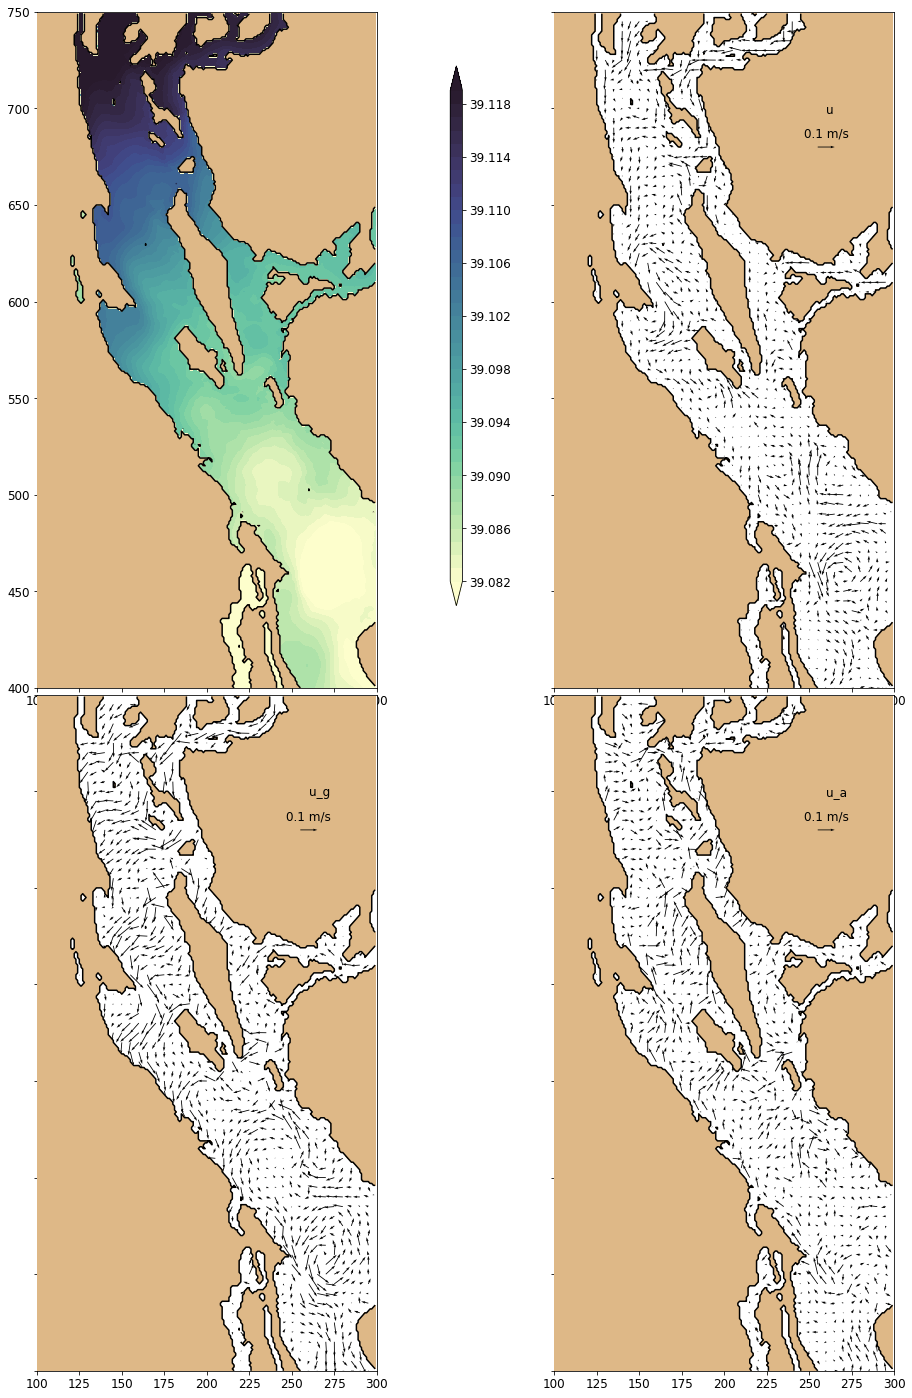

In [101]:
GEO = calc_geostrophic_velocities(z, params)
plotit(z, GEO, params, plevels=np.arange(39.082, 39.12, 0.001), scales=[2, 2, 2], layout='grid', lims=lims)

### With correction

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


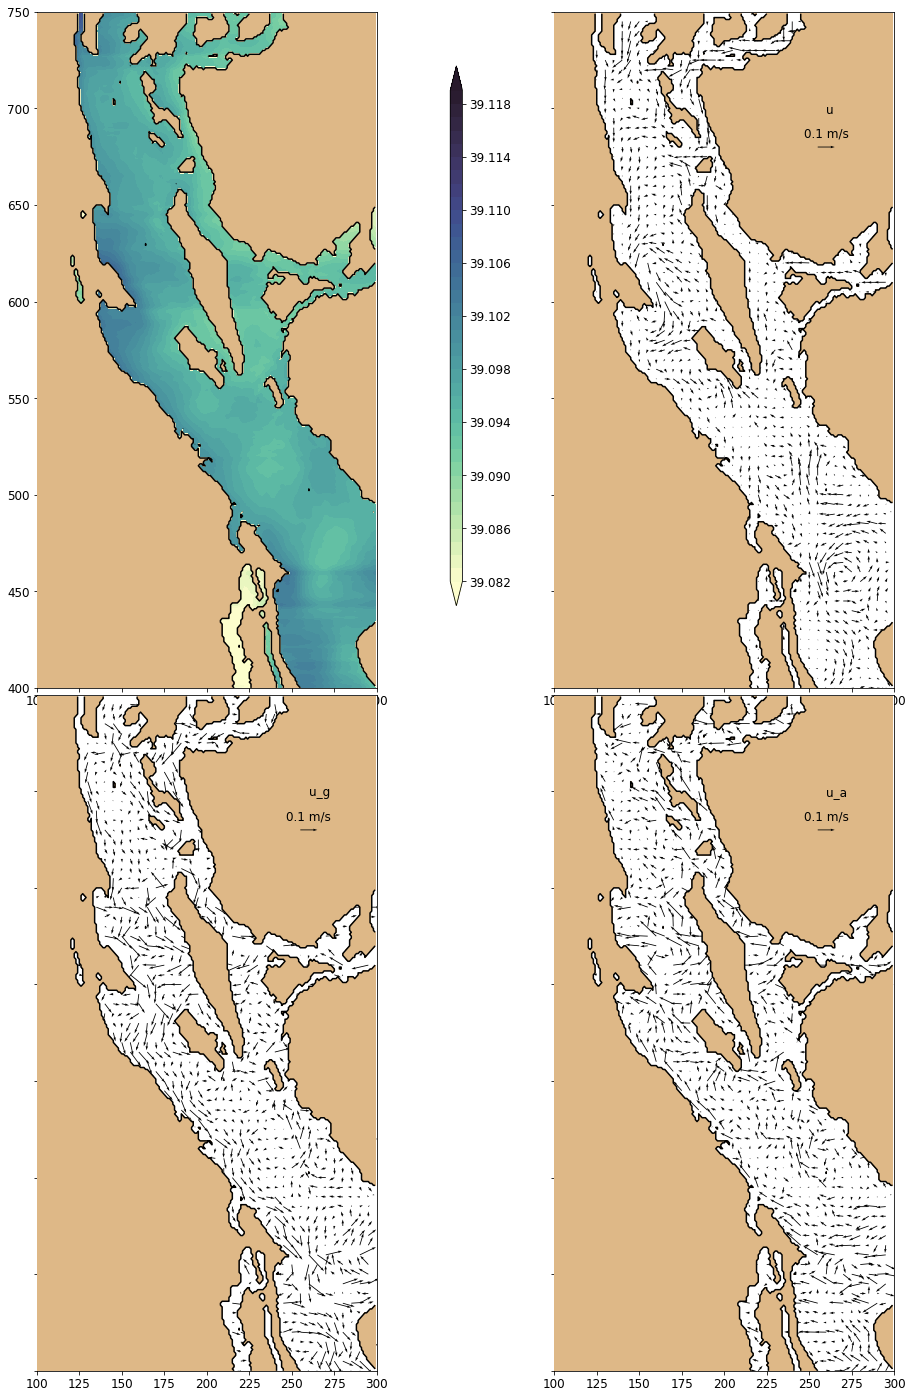

In [102]:
GEO = calc_geostrophic_velocities(z, params, corr=True)
plotit(z, GEO, params, plevels=np.arange(39.082, 39.12, 0.001), scales=[2, 2, 2], layout='grid', lims=lims)